In [1]:
#import the picture
import cv2
import numpy as np

import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import pandas as pd

In [3]:
# Specify the file path of the image
image_path = "frame_0.png"

# Read the image
image_input = cv2.imread(image_path)

# Check if the image was successfully read
if image_input is not None:
    # Image was read successfully
    print("Image read successfully!")
else:
    # Failed to read the image
    print("Failed to read the image.")

Image read successfully!


In [4]:
# import reference points
#image_data_path = "input_trial.dat"
image_data_path = f"{image_path}.dat"

### it contains the 4 uv coordinates of the reference points, making a rectangle P1-P2-P3-P4, in the first 4 lines,
### and then the Height (P1-P2) and Width (P1-P4) of the rectangle.
with open(image_data_path,"r") as f:
    reference_points = f.readlines()
    reference_points = [x.strip() for x in reference_points]
ps=np.array([ [float(y) for y in x.split()] for x in reference_points[0:4]])
H,W=[ float(x) for x in reference_points[4:6]] #
Ps=np.array([[0,0,0],[0,H,0],[W,H,0],[W,0,0]])
h,w,_=image_input.shape
print(  f'{w=}, {h=}')
ps0=np.array([[(w-1)*0.5,(h-1)*0.5]]*4)
ps,H,W,ps0,Ps

w=1280, h=720


(array([[222., 672.],
        [166., 198.],
        [800.,  68.],
        [996., 451.]]),
 0.21,
 0.297,
 array([[639.5, 359.5],
        [639.5, 359.5],
        [639.5, 359.5],
        [639.5, 359.5]]),
 array([[0.   , 0.   , 0.   ],
        [0.   , 0.21 , 0.   ],
        [0.297, 0.21 , 0.   ],
        [0.297, 0.   , 0.   ]]))

In [5]:
# copy image_input
image = image_input.copy()

# write 3 circles at ps on the image
for i in range(4):
    image = cv2.circle(image, (int(ps[i][0]), int(ps[i][1])), 25, (0, 0, 255), -1)

#write a line between the each pair of points
for i in range(4):
    image = cv2.line(image, (int(ps[i][0]), int(ps[i][1])), (int(ps[(i+1)%4][0]), int(ps[(i+1)%4][1])), (0, 0, 255), 5)

# write the distance (ds) between the points belong the line above
for i in range(4):
    if i%2==0:
        image = cv2.putText(image, str(H), (int((ps[i][0]+ps[(i+1)%4][0])/2), int((ps[i][1]+ps[(i+1)%4][1])/2)), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 0), 2)
    if i%2==1:
        image = cv2.putText(image, str(W), (int((ps[i][0]+ps[(i+1)%4][0])/2), int((ps[i][1]+ps[(i+1)%4][1])/2)), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 0), 2)

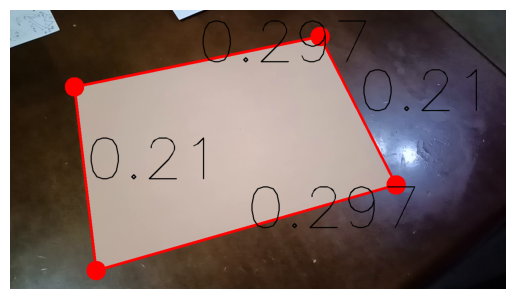

In [6]:
#save the image
cv2.imwrite('output.jpg', image)

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



In [7]:
# Define a RotationMatrix class
# It includes the following attributes:
# -  3 angles defining the rotation matrix. (kappa, phi, omega)
# return the li,mi,ni (i=0,1,2) for te given angles
# 
class RotationMatrix:
    def __init__(self, omega: float, phi: float, kappa: float):
        self.kappa :float = kappa
        self.phi :float = phi
        self.omega :float = omega
        
        self.matrix_x= np.array([[1, 0, 0], [0, np.cos(omega), -np.sin(omega)], [0, np.sin(omega), np.cos(omega)]])
        self.matrix_y= np.array([[np.cos(phi), 0, np.sin(phi)], [0, 1, 0], [-np.sin(phi), 0, np.cos(phi)]])
        self.matrix_z= np.array([[np.cos(kappa), -np.sin(kappa), 0], [np.sin(kappa), np.cos(kappa), 0], [0, 0, 1]])
        self.matrix = self.matrix_z @ self.matrix_y @ self.matrix_x

        self.dmatrix_x_domega= np.array([[0, 0, 0], [0, -np.sin(omega), -np.cos(omega)], [0, np.cos(omega), -np.sin(omega)]])
        self.dmatrix_y_dphi= np.array([[-np.sin(phi), 0, np.cos(phi)], [0, 0, 0], [-np.cos(phi), 0, -np.sin(phi)]])
        self.dmatrix_z_dkappa= np.array([[-np.sin(kappa), -np.cos(kappa), 0], [np.cos(kappa), -np.sin(kappa), 0], [0, 0, 0]])
        self.matrix_domega = self.matrix_z @ self.matrix_y @ self.dmatrix_x_domega
        self.matrix_dphi = self.matrix_z @ self.dmatrix_y_dphi @ self.matrix_x
        self.matrix_dkappa = self.dmatrix_z_dkappa @ self.matrix_y @ self.matrix_x

    def __str__(self):
        return f'omega={self.omega}, phi={self.phi}, kappa={self.kappa}\nMatrix={self.matrix}'
    def __repr__(self):
        return self.matrix.__repr__()

# Define a DistanceConstraint class
# It includes the following attributes:
# -  2 points \in R3 defining the distance constraint. (p1, p2)
# -  The distance between the 2 points. (d)
# return the partial derivatives of the distance constraint
#
class DistanceConstraint:
    def __init__(self, X1: np.array, X2: np.array, d: float):
        self.X1 = X1
        self.X2 = X2
        self.dX = X1-X2
        self.d = d
        self.error = self.dX[0]**2 + self.dX[1]**2 - d**2
        self.derror_dxy = np.array([[2*self.dX[0], -2*self.dX[0]],[2*self.dX[1], -2*self.dX[1]]])# [de/dx1, de/dx2], [de/dy1, de/dy2]
        
    def __str__(self):
        return f'error={self.error}'

# Define a ColinearityConstraint class
# It includes the following attributes:
# -  RotationMatrix object
# -  focal length (c)
# -  a pair of points \in R2  on the image and the corresponding 3d points \in R3. (p, X)
# return the partial derivatives of the colinearity constraint
#
class ColinearityConstraint:
    def __init__(self, # rotation_matrix: RotationMatrix, c:float , 
                 Xs: np.array, p: np.array, P:np.array):
        
        self.rotation_matrix = RotationMatrix(Xs[3], Xs[4], Xs[5])
        self.p = p
        self.X = P-Xs[0:3]
        self.c= Xs[6]
        self.inv_c = 1/self.c

        x_hat = np.dot(self.rotation_matrix.matrix[:,0], self.X)
        y_hat = np.dot(self.rotation_matrix.matrix[:,1], self.X)
        z_hat = np.dot(self.rotation_matrix.matrix[:,2], self.X)
        inv_z_hat = 1/z_hat
        dx_hat_domega = np.dot(self.rotation_matrix.matrix_domega[:,0], self.X)
        dy_hat_domega = np.dot(self.rotation_matrix.matrix_domega[:,1], self.X)
        dz_hat_domega = np.dot(self.rotation_matrix.matrix_domega[:,2], self.X)
        dx_hat_dphi = np.dot(self.rotation_matrix.matrix_dphi[:,0], self.X)
        dy_hat_dphi = np.dot(self.rotation_matrix.matrix_dphi[:,1], self.X)
        dz_hat_dphi = np.dot(self.rotation_matrix.matrix_dphi[:,2], self.X)
        dx_hat_dkappa = np.dot(self.rotation_matrix.matrix_dkappa[:,0], self.X)
        dy_hat_dkappa = np.dot(self.rotation_matrix.matrix_dkappa[:,1], self.X)
        dz_hat_dkappa = np.dot(self.rotation_matrix.matrix_dkappa[:,2], self.X)
        dx_hat_dangle = np.array([dx_hat_domega, dx_hat_dphi, dx_hat_dkappa])
        dy_hat_dangle = np.array([dy_hat_domega, dy_hat_dphi, dy_hat_dkappa])
        dz_hat_dangle = np.array([dz_hat_domega, dz_hat_dphi, dz_hat_dkappa])

        # [eX, eY]
        self.error =np.array([p[0]*self.inv_c - x_hat*inv_z_hat,
                                p[1]*self.inv_c - y_hat*inv_z_hat]) 

        self.de_dx=np.array([   ### ∂eX/∂(x,y,z,omega,phi,kappa,c)
                                [0,0,0,  #∂eX/∂(x,y,z)
                                0,0,0,  #∂eX/∂(omega,phi,kappa)
                                -p[0]*self.inv_c**2],# ∂eX/∂c
                                ### ∂eY/∂(x,y,z,omega,phi,kappa,c)
                                [0,0,0,  #∂eX/∂(x,y,z)
                                0,0,0,  #∂eX/∂(omega,phi,kappa)
                                -p[1]*self.inv_c**2]])
        ### The sign of the partial derivatives of x,y,z is negative,
        ### because the definition of self.X is P-Xs[0:3] and not Xs[0:3].
        self.de_dx[0,0:3]=-(x_hat*inv_z_hat *self.rotation_matrix.matrix[:,2] - self.rotation_matrix.matrix[:,0])*inv_z_hat
        self.de_dx[1,0:3]=-(y_hat*inv_z_hat *self.rotation_matrix.matrix[:,2] - self.rotation_matrix.matrix[:,1])*inv_z_hat
        self.de_dx[0,3:6]=(x_hat*inv_z_hat *dz_hat_dangle - dx_hat_dangle)*inv_z_hat
        self.de_dx[1,3:6]=(y_hat*inv_z_hat *dz_hat_dangle - dy_hat_dangle)*inv_z_hat
        
        # self.derror_dxyz = np.array([[ self.rotation_matrix.matrix[i,0] - p[0]*self.inv_c*rotation_matrix.matrix[i,2] for i in range(3)],# [deX/dX, deX/dY, deX/dZ]
        #                               [ self.rotation_matrix.matrix[i,1] - p[1]*self.inv_c*rotation_matrix.matrix[i,2] for i in range(3)]])# [deY/dX, deY/dY, deY/dZ]
        # # [deX/domega, deY/domega]
        # self.derror_domega = np.array([np.dot(self.rotation_matrix.matrix_domega[:,0],X)- p[0]*self.inv_c*np.dot(self.rotation_matrix.matrix_domega[:,2],X),
        #                                  np.dot(self.rotation_matrix.matrix_domega[:,1],X)- p[1]*self.inv_c*np.dot(self.rotation_matrix.matrix_domega[:,2],X)])
        # # [deX/dphi, deY/dphi]
        # self.derror_dphi = np.array([np.dot(self.rotation_matrix.matrix_dphi[:,0],X)- p[0]*self.inv_c*np.dot(self.rotation_matrix.matrix_dphi[:,2],X),
        #                                  np.dot(self.rotation_matrix.matrix_dphi[:,1],X)- p[1]*self.inv_c*np.dot(self.rotation_matrix.matrix_dphi[:,2],X)])
        # # [deX/dkappa, deY/dkappa]
        # self.derror_dkappa = np.array([np.dot(self.rotation_matrix.matrix_dkappa[:,0],X)- p[0]*self.inv_c*np.dot(self.rotation_matrix.matrix_dkappa[:,2],X),
        #                                  np.dot(self.rotation_matrix.matrix_dkappa[:,1],X)- p[1]*self.inv_c*np.dot(self.rotation_matrix.matrix_dkappa[:,2],X)])

    def __str__(self):
        return f'errorX={self.error[0]}\n\terrorY={self.error[1]}'


In [8]:
for i in range(10):
    r=random.random()*2*np.pi
    omega,phi,kappa = r-0.5,  2*(r-0.5),3*(r-0.5)
    R=RotationMatrix(omega,phi,kappa)
    R1=RotationMatrix(omega+np.pi,np.pi-phi,kappa+np.pi)
    r=[random.random() for i in range(3)]
    print(R.matrix@np.array(r)-R1.matrix@np.array(r))

[ 2.22044605e-16 -5.55111512e-17  0.00000000e+00]
[ 1.11022302e-15 -1.66533454e-15 -2.35922393e-16]
[-1.11022302e-16 -1.11022302e-16 -5.55111512e-17]
[ 0.00000000e+00 -1.11022302e-16  1.94289029e-16]
[ 0.00000000e+00  1.11022302e-16 -6.93889390e-17]
[ 7.21644966e-16  1.11022302e-16 -6.66133815e-16]
[-5.55111512e-16 -4.44089210e-16 -2.22044605e-16]
[0.00000000e+00 5.55111512e-17 0.00000000e+00]
[-2.77555756e-16  1.11022302e-16 -3.33066907e-16]
[-1.38777878e-16  0.00000000e+00 -8.32667268e-17]


In [9]:
def normalize_angle(Xs: np.array):
    #This process doesn't change the Rotation Matrix.
    #omega
    while Xs[3]>np.pi: 
        Xs[3]-=2*np.pi
    while Xs[3]< -np.pi:
        Xs[3]+=2*np.pi
    if Xs[3]<0:
        Xs[3]+=np.pi#omega
        Xs[4]=np.pi-Xs[4]#phi
        Xs[5]+=np.pi#kappa
    # phi
    while Xs[4]>np.pi:
        Xs[4]-=2*np.pi
    while Xs[4]< -np.pi:
        Xs[4]+=2*np.pi

    # kappa
    while Xs[5]>np.pi:
        Xs[5]-=2*np.pi
    while Xs[5]< -np.pi:
        Xs[5]+=2*np.pi
    
    return Xs
    


In [10]:
#initialize
Xs=np.array([-random.random()*W,-random.random()*W,random.random()*W,
            random.random()*np.pi,random.random()*np.pi*2,random.random()*np.pi*2,
            w])

In [11]:
int(27)*w/36.0,int(27)*h/24.0, Xs[6]

(960.0, 810.0, 1280.0)

In [12]:
max_iter=500
Xs_collect=np.zeros((max_iter,7))
b_collect=np.zeros((max_iter,8))
for iter in range(max_iter):
    # if Xs[0,2]>0:
    #     Xs[:,(1,2)]=-Xs[:,(1,2)]
    # if Xs[1,1]-Xs[0,1]<0:
    #     Xs[:,0:2]=-Xs[:,0:2]
    
    Xs=normalize_angle(Xs)

    #R=RotationMatrix(omega,phi,kappa)
    # if iter>0 and np.dot(R.matrix.T[2,:],Xs[0,:])<0 and np.dot(R.matrix.T[2,:],Xs[1,:])<0 and np.dot(R.matrix.T[2,:],Xs[2,:])<0  :
    #     print("pose inversion(1) activated.")
    #     phi+=np.pi
    #     kappa=-kappa
    #     R=RotationMatrix(omega,phi,kappa)
    colinearity_constraint=[ColinearityConstraint(Xs,ps0[i]-ps[i],Ps[i]) for i in range(4)]
    

    A=np.zeros((8,7))
    b=np.zeros(8)

    for i in range(4):
        A[2*i:2*(i+1),:]=colinearity_constraint[i].de_dx
        b[2*i:2*(i+1)]= - colinearity_constraint[i].error

    try:
        dx=np.linalg.inv(A.T@A)@A.T@b
    except np.linalg.LinAlgError:
        print("Singular Matrix")
        break

    dx=normalize_angle(dx)
    alpha=0.1
    Xs+=dx*alpha
    
    r_b=np.linalg.norm(b)
    r_dx=np.linalg.norm(dx)
    if iter%1==0:
        print(f'iteration {iter} : \t{r_b}, \t{r_dx}')
        # for i in range(3):
        #     print("\t",distance_constraint[i])
        # for i in range(3):
        #     print("\t",colinearity_constraint[i])
        # print("\t",Xs,omega,phi,kappa)
        #print(np.linalg.det(A),np.dot(R.matrix.T[2,:],Xs[0,:]), np.dot(R.matrix.T[2,:],Xs[1,:]), np.dot(R.matrix.T[2,:],Xs[2,:]))
    r_dx=np.linalg.norm(dx)
    if r_b<1e-4 and r_dx<1e-6:
        break
    
    # restrict the c range.
    # If not, the XYZ,c values will explode.
    if Xs[6]>5*w:
        Xs[(0,1,2,6),]=Xs[(0,1,2,6),]/Xs[6]*w

    elif Xs[6]<0.5*w:
        Xs[(0,1,2,6),]=Xs[(0,1,2,6),]/Xs[6]*w
    Xs_collect[iter,:]=Xs
    b_collect[iter,:]=b
Xs

iteration 0 : 	2.6441206031210087, 	175.7653571916604
iteration 1 : 	3.3001261987865464, 	476.0251346467633
iteration 2 : 	2.9944209238344075, 	412.47823789937246
iteration 3 : 	2.7166017670642306, 	364.56347862563536
iteration 4 : 	2.4641954567959954, 	335.99746691465975
iteration 5 : 	2.234924614668571, 	327.1591001598629
iteration 6 : 	2.0267178073518433, 	336.0962884579866
iteration 7 : 	1.3586399457715972, 	236.2880878003788
iteration 8 : 	1.1395195680364567, 	319.44827488128993
iteration 9 : 	0.9614482813883679, 	400.05656558159626
iteration 10 : 	0.8264857255957023, 	470.61077420972344
iteration 11 : 	0.7251183529553067, 	528.9320260009338
iteration 12 : 	0.7384500358254393, 	498.92966192318727
iteration 13 : 	0.6723371175855343, 	537.2821905612799
iteration 14 : 	0.6122220327731026, 	581.5153332391158
iteration 15 : 	0.5575227104054526, 	632.1962073358887
iteration 16 : 	0.5077611725933133, 	690.1625592068312
iteration 17 : 	0.4625121078571496, 	756.5362744708144
iteration 18 :

array([-4.80570089e-03,  1.10777159e-03,  1.33934831e-02,  5.15475950e-01,
       -2.29924074e+00,  2.82271360e+00,  2.29731831e+03])

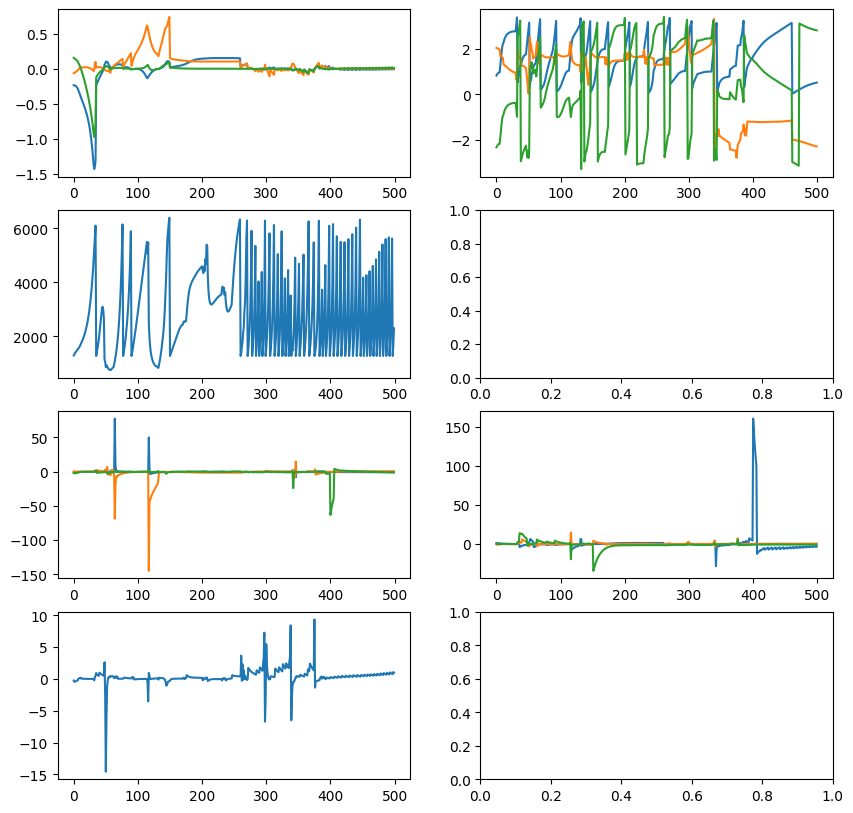

In [13]:
# plot Xs_collects on 3 subplots (Xs[(0,1,2)], Xs[(3,4,5)], Xs[6])
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
axs[0,0].plot(Xs_collect[:,(0,1,2)])
axs[0,1].plot(Xs_collect[:,(3,4,5)])
axs[1,0].plot(Xs_collect[:,6])
axs[2,0].plot(b_collect[:,(0,1,2)])
axs[2,1].plot(b_collect[:,(3,4,5)])
axs[3,0].plot(b_collect[:,6])
plt.show()

In [14]:
w,h

(1280, 720)

In [15]:
Xs,dx

(array([-4.80570089e-03,  1.10777159e-03,  1.33934831e-02,  5.15475950e-01,
        -2.29924074e+00,  2.82271360e+00,  2.29731831e+03]),
 array([-1.83461621e-02,  3.93183558e-03,  5.25334332e-02,  7.03612564e-02,
        -5.35087591e-02, -6.85464637e-02,  6.22291057e+03]))

In [16]:
max_iter=400
max_trial=100
bool_convergence=False
Xs_collect=np.zeros((max_trial,7))
b_collect=np.zeros((max_trial,8))
for num_trial in range(max_trial):
    print(f'trial {num_trial}')
    if bool_convergence:
        break
    #initialize
    Xs=np.array([random.random()*W,random.random()*W,random.random()*W,
            random.random()*np.pi,random.random()*np.pi*2,random.random()*np.pi*2,
            w])
    for iter in range(max_iter):
        # if Xs[0,2]>0:
        #     Xs[:,(1,2)]=-Xs[:,(1,2)]
        # if Xs[1,1]-Xs[0,1]<0:
        #     Xs[:,0:2]=-Xs[:,0:2]
        
        Xs=normalize_angle(Xs)

        #R=RotationMatrix(omega,phi,kappa)
        # if iter>0 and np.dot(R.matrix.T[2,:],Xs[0,:])<0 and np.dot(R.matrix.T[2,:],Xs[1,:])<0 and np.dot(R.matrix.T[2,:],Xs[2,:])<0  :
        #     print("pose inversion(1) activated.")
        #     phi+=np.pi
        #     kappa=-kappa
        #     R=RotationMatrix(omega,phi,kappa)
        colinearity_constraint=[ColinearityConstraint(Xs,ps0[i]-ps[i],Ps[i]) for i in range(4)]
        

        A=np.zeros((8,7))
        b=np.zeros(8)

        for i in range(4):
            A[2*i:2*(i+1),:]=colinearity_constraint[i].de_dx
            b[2*i:2*(i+1)]= - colinearity_constraint[i].error

        try:
            dx=np.linalg.inv(A.T@A)@A.T@b
        except np.linalg.LinAlgError:
            print("Singular Matrix")
            break

        dx=normalize_angle(dx)
        alpha=0.1
        Xs+=dx*alpha
        
        r_b=np.linalg.norm(b)
        r_dx=np.linalg.norm(dx)
        if iter%1==0:
            None
            #print(f'iteration {iter} : \t{r_b}, \t{r_dx}')
            
        r_dx=np.linalg.norm(dx)
        if r_dx<1e-8:
            print("converged. C:"   ,Xs[6])
            break
        
        # restrict the c range.
        # If not, the XYZ,c values will explode.
        if Xs[6]>3*w:
            Xs[(0,1,2,6),]=Xs[(0,1,2,6),]/Xs[6]*w
        elif Xs[6]<0.3*w:
            Xs[(0,1,2,6),]=Xs[(0,1,2,6),]/Xs[6]*w
    Xs_collect[num_trial,:]=Xs
    b_collect[num_trial,:]=b

  
Xs

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
converged. C: 1036.3902245985341
trial 8
trial 9
trial 10
converged. C: 1036.3902245797885
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
converged. C: 1036.3902245974796
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
converged. C: 1036.3902245978265
trial 24
converged. C: 1036.3902245979668
trial 25
trial 26
trial 27
trial 28
trial 29
trial 30
trial 31
converged. C: 1036.3902245983888
trial 32
trial 33
converged. C: 1036.3902245804888
trial 34
converged. C: 1036.390224597685
trial 35
converged. C: 1036.3902245982522
trial 36
trial 37
trial 38
trial 39
trial 40
trial 41
trial 42
trial 43
trial 44
trial 45
trial 46
trial 47
trial 48
trial 49
trial 50
converged. C: 1036.3902245974903
trial 51
trial 52
trial 53
trial 54
trial 55
trial 56
trial 57
trial 58
trial 59
trial 60
converged. C: 1036.3902245976844
trial 61
trial 62
trial 63
trial 64
converged. C: 1036.390224593774
trial 65
trial 66
trial 67
conv

array([-4.70743669e-03,  8.56535689e-04,  1.88469621e-02,  4.76634741e-01,
       -2.37731661e+00,  2.88782367e+00,  2.33455694e+03])

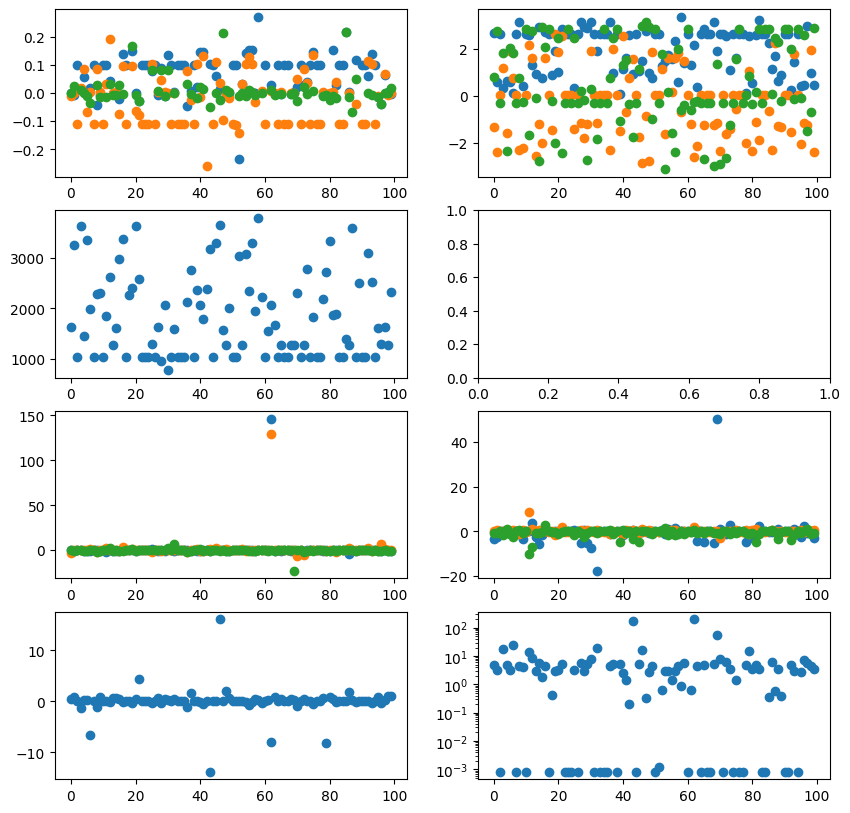

In [17]:
# plot Xs_collects on 3 subplots (Xs[(0,1,2)], Xs[(3,4,5)], Xs[6])
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
x=np.arange(0,max_trial,1)
for i in range(3):
    axs[0,0].scatter(x,Xs_collect[:,(0,1,2)[i]])
    axs[0,1].scatter(x,Xs_collect[:,(3,4,5)[i]])
    axs[2,0].scatter(x,b_collect[:,(0,1,2)[i]])
    axs[2,1].scatter(x,b_collect[:,(3,4,5)[i]])

axs[1,0].scatter(x,Xs_collect[:,6])
axs[3,0].scatter(x,b_collect[:,6])
norm_b=np.linalg.norm(b_collect[:,:],axis=1)
axs[3,1].scatter(x,norm_b)
# set y axis log scale
axs[3,1].set_yscale('log')

axs[0,0].set_ylim(-W,W)
plt.show()

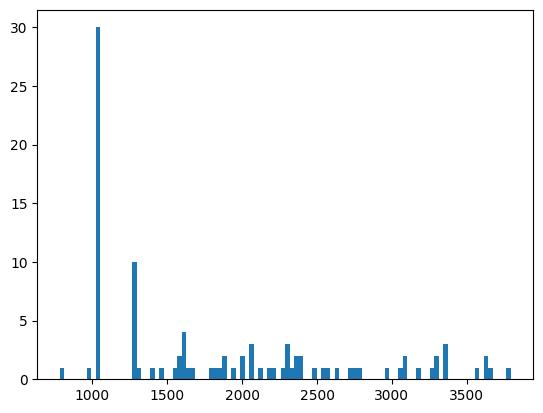

In [18]:
# create histogram of Xs_collects[:,6] 
x=plt.hist(Xs_collect[:,6], bins=100)
plt.show()


In [19]:
# export collects in a csv format

df=pd.DataFrame(columns=['X','Y','Z','omega','phi','kappa','c']+[f'b{i+1}' for i in range(7)])
precision=8
Xs_collect=Xs_collect.round(precision)
for i in range(7):
    df[df.columns[i]]  =Xs_collect[:,i]
df.round(precision)
for i in range(7):
    df[f'b{i+1}']=b_collect[:,i]

# # add a column for the x increment
# for i in range(9):
#     df[f'dX{i+1}']=dXs_collect[i,:]

# add a column of the square error (b@b)
df["SE"]=norm_b

df=df.sort_values(by='SE',ascending=True)
display(df,df.describe())
#display(df)
#df.to_csv("output.csv")
with pd.option_context('display.max_rows', None,):
    print(df[['X', 'Y', 'Z', 'omega', 'phi', 'kappa', 'c',"SE"]].to_markdown)

,X,Y,Z,omega,phi,kappa,c,b1,b2,b3,b4,b5,b6,b7,SE
17,0.098412,-0.111154,0.368704,2.639512,0.043946,2.840439,1036.390225,0.000017,-0.000193,0.000120,0.000006,-0.000568,-0.000212,0.000333,0.000825
33,0.098412,-0.111154,-0.368704,2.639512,0.043946,-0.301153,1036.390225,0.000017,-0.000193,0.000120,0.000006,-0.000568,-0.000212,0.000333,0.000825
34,0.098412,-0.111154,0.368704,2.639512,0.043946,2.840439,1036.390225,0.000017,-0.000193,0.000120,0.000006,-0.000568,-0.000212,0.000333,0.000825
35,0.098412,-0.111154,-0.368704,2.639512,0.043946,-0.301153,1036.390225,0.000017,-0.000193,0.000120,0.000006,-0.000568,-0.000212,0.000333,0.000825
60,0.098412,-0.111154,0.368704,2.639512,0.043946,2.840439,1036.390225,0.000017,-0.000193,0.000120,0.000006,-0.000568,-0.000212,0.000333,0.000825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,0.004496,0.000820,0.001637,1.923520,-1.157093,-1.814990,1583.596082,-0.454315,0.024354,7.213859,-17.588684,0.488641,-0.741315,0.375371,19.041433
6,0.017324,0.003705,-0.037109,0.116718,0.761124,1.800681,1992.874098,-1.329669,1.078845,0.543527,-0.182712,0.644588,-2.240919,-6.516841,25.545152
69,0.004142,0.000981,-0.001447,1.899900,-1.155086,1.340746,1280.000000,-0.205904,-0.194305,-22.907812,50.515955,0.428001,-0.616054,0.199511,55.473746
43,0.102582,0.412702,-0.048837,0.939932,1.565973,-1.754171,3172.596890,-0.313329,1.437096,-0.422851,0.820235,0.549644,-3.461687,-13.778281,178.650092


,X,Y,Z,omega,phi,kappa,c,b1,b2,b3,b4,b5,b6,b7,SE
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.512674,-0.506288,0.076637,1.906319,-0.321101,0.493815,1852.836798,1.198002,1.375425,-0.305151,-0.155058,0.201744,-0.681378,-0.015449,7.684373
std,4.260740,3.623997,0.903428,0.959269,1.444075,1.795571,842.074696,14.693020,12.979132,2.467791,5.685208,1.036480,1.641944,2.597240,26.670799
min,-41.149936,-35.116616,-0.993258,0.094439,-2.853854,-3.096100,783.545663,-4.415815,-6.265443,-22.907812,-17.588684,-2.787107,-10.027317,-13.778281,0.000825
25%,-0.001906,-0.111154,-0.026449,0.985218,-1.413802,-0.308399,1036.390226,-0.480306,-0.000193,-0.408577,-0.414986,-0.000568,-0.973087,-0.004094,0.000825
50%,0.059547,-0.008318,-0.002629,2.557714,0.043943,-0.091565,1617.509091,-0.026508,-0.000187,-0.055010,0.000006,0.062892,-0.133792,0.000333,2.943859
75%,0.098412,0.032705,0.029608,2.639512,0.072400,2.445422,2365.322048,0.000017,0.507398,0.000120,0.115861,0.442193,-0.000212,0.419548,4.974780
max,0.462674,0.412702,8.606684,3.348624,2.605782,3.117608,3793.721301,146.483865,129.113922,7.213859,50.515955,8.568867,3.051974,16.052037,195.448935


<bound method DataFrame.to_markdown of             X          Y         Z     omega       phi     kappa            c  \
17   0.098412  -0.111154  0.368704  2.639512  0.043946  2.840439  1036.390225   
33   0.098412  -0.111154 -0.368704  2.639512  0.043946 -0.301153  1036.390225   
34   0.098412  -0.111154  0.368704  2.639512  0.043946  2.840439  1036.390225   
35   0.098412  -0.111154 -0.368704  2.639512  0.043946 -0.301153  1036.390225   
60   0.098412  -0.111154  0.368704  2.639512  0.043946  2.840439  1036.390225   
26   0.098412  -0.111154 -0.368704  2.639512  0.043946 -0.301153  1036.390225   
76   0.098412  -0.111154  0.368704  2.639512  0.043946  2.840439  1036.390225   
84   0.098412  -0.111154  0.368704  2.639512  0.043946  2.840439  1036.390225   
91   0.098412  -0.111154  0.368704  2.639512  0.043946  2.840439  1036.390225   
67   0.098412  -0.111154 -0.368704  2.639512  0.043946 -0.301153  1036.390225   
50   0.098412  -0.111154  0.368704  2.639512  0.043946  2.840439  1036

In [20]:
df.to_csv(f"{image_path}_output.csv")

In [21]:
display(df)

,X,Y,Z,omega,phi,kappa,c,b1,b2,b3,b4,b5,b6,b7,SE
17,0.098412,-0.111154,0.368704,2.639512,0.043946,2.840439,1036.390225,0.000017,-0.000193,0.000120,0.000006,-0.000568,-0.000212,0.000333,0.000825
33,0.098412,-0.111154,-0.368704,2.639512,0.043946,-0.301153,1036.390225,0.000017,-0.000193,0.000120,0.000006,-0.000568,-0.000212,0.000333,0.000825
34,0.098412,-0.111154,0.368704,2.639512,0.043946,2.840439,1036.390225,0.000017,-0.000193,0.000120,0.000006,-0.000568,-0.000212,0.000333,0.000825
35,0.098412,-0.111154,-0.368704,2.639512,0.043946,-0.301153,1036.390225,0.000017,-0.000193,0.000120,0.000006,-0.000568,-0.000212,0.000333,0.000825
60,0.098412,-0.111154,0.368704,2.639512,0.043946,2.840439,1036.390225,0.000017,-0.000193,0.000120,0.000006,-0.000568,-0.000212,0.000333,0.000825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,0.004496,0.000820,0.001637,1.923520,-1.157093,-1.814990,1583.596082,-0.454315,0.024354,7.213859,-17.588684,0.488641,-0.741315,0.375371,19.041433
6,0.017324,0.003705,-0.037109,0.116718,0.761124,1.800681,1992.874098,-1.329669,1.078845,0.543527,-0.182712,0.644588,-2.240919,-6.516841,25.545152
69,0.004142,0.000981,-0.001447,1.899900,-1.155086,1.340746,1280.000000,-0.205904,-0.194305,-22.907812,50.515955,0.428001,-0.616054,0.199511,55.473746
43,0.102582,0.412702,-0.048837,0.939932,1.565973,-1.754171,3172.596890,-0.313329,1.437096,-0.422851,0.820235,0.549644,-3.461687,-13.778281,178.650092
